### 一、项目简介
* 本项目将利用Keras建立CNN模型对验证码数字进行识别，展示数字验证码识别的基本流程。
* 此项目不采用OpenCV工具包的数字识别功能，而是将rgb数字图像转化为gray灰度图，计算图片的像素值进行模型训练和识别。
* 验证码的训练集和测试集事先已生成，可直接调用。

### 二、数据预处理

#### 1、引入第三方工具包

In [1]:
from PIL import Image 
from keras import backend as K
from keras.models import * 
from keras.layers import * 
import tensorflow as tf
import glob,pickle
import numpy as np 
import tensorflow.gfile as gfile 
import matplotlib.pyplot as mp

Using TensorFlow backend.


#### 2、定义超参数和字符集

In [49]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

CAPTCHA_CHARSET = NUMBER   # 使用数字字符集生成验证码
CAPTCHA_LEN = 4            # 验证码长度
CAPTCHA_HEIGHT = 60        # 验证码高度
CAPTCHA_WIDTH = 160       # 验证码长度

TRAIN_DATA_DIR = './train_data/' # 验证码训练数据集路径
TEST_DATA_DIR = './test_data/'

BATCH_SIZE = 100    # 每个批次训练样本的数量
EPOCHS = 10        # 模型训练的轮数
OPT = 'adam'        # 采用adam算法进行模型优化
LOSS = 'binary_crossentropy' # 采用二分交叉熵损失函数，向量的分量相互独立

# 模型文件存储路径和文件格式
MODEL_DIR = './model/train_demo/'
MODEL_FORMAT = '.h5'
# 训练记录文件存储路径和文件格式
HISTORY_DIR = './history/train_demo/'
HISTORY_FORMAT = '.history'

# 训练日志内容格式
filename_str = "{} captcha_{}_{}_bs_{}_epochs_{}{}"

# # 模型网络结构文件
# MODEL_VIS_FILE = 'captcha_classification.png'
# 模型文件
MODEL_FILE = filename_str.format(MODEL_DIR, OPT, LOSS, str(BATCH_SIZE),
                                str(EPOCHS),MODEL_FORMAT)
# 训练记录文件
HISTORY_FILE = filename_str.format(HISTORY_DIR, OPT, LOSS, str(BATCH_SIZE),
                                str(EPOCHS),HISTORY_FORMAT)

#### 3、将RGB图像转化为灰度图

In [3]:
def rgb2gray(image):
    return np.dot(image[...,:3], [0.299,0.587,0.114])

#### 4、对验证码进行one-hot编码

In [4]:
def text2vec(text, length=CAPTCHA_LEN, charset=CAPTCHA_CHARSET):
    text_len = len(text)
    # 验证码长度校验
    if text_len != length:
        raise ValueError(
            "输入字符长度为{}，与所需验证码长度{}不相符".format(text_len,length))
    vec = np.zeros(length*len(charset))
    for i in range(length):
        vec[charset.index(text[i])+i*len(charset)] = 1
    return vec

#### 5、将验证码向量解码为对应字符

In [5]:
def vec2text(vector):
    if not isinstance(vector, np.ndarray):
        vector = np.asarray(vector)
    vector = np.reshape(vector, [CAPTCHA_LEN, -1])
    text = ''
    for item in vector:
        text += CAPTCHA_CHARSET[np.argmax(item)]
    return text

#### 6、适配Keras图像数据格式通道

In [6]:
def fit_keras_channels(batch, rows=CAPTCHA_HEIGHT, cols=CAPTCHA_WIDTH):
    if K.image_data_format() == 'channel first':
        batch = batch.reshape(batch.shape[0],1,rows,cols)
        input_shape = (1,rows,cols)
    else:
        batch = batch.reshape(batch.shape[0],rows,cols,1)
        input_shape = (rows,cols,1)
    return batch,input_shape

#### 7、读取训练集数据

In [37]:
X_train, Y_train = [],[]
for filename in glob.glob(TRAIN_DATA_DIR + '*.png'):
    X_train.append(np.array(Image.open(filename)))
    Y_train.append(filename.lstrip(TRAIN_DATA_DIR+'\\').rstrip('.png'))

In [39]:
Y_train[9]

'0029'

#### 8、处理训练集图像

In [40]:
# 将X_train格式转为rgb的np.float32型的numpy数组格式
X_train = np.array(X_train, dtype=np.float32)
# 将数据由rgb图转为gray灰度图
X_train = rgb2gray(X_train)
# 数据归一化
X_train = X_train / 255
# 适配Keras数据通道
X_train, input_shape = fit_keras_channels(X_train)

print(X_train.shape, type(X_train))
print(input_shape)

(3936, 60, 160, 1) <class 'numpy.ndarray'>
(60, 160, 1)


In [42]:
Y_train[8]

'0028'

#### 9、处理训练集标签

In [43]:
Y_train = list(Y_train)
for i in range(len(Y_train)):
#     print(Y_train[i])
    Y_train[i] = text2vec(Y_train[i])
Y_train = np.asarray(Y_train)

print(Y_train.shape, type(Y_train))

(3936, 40) <class 'numpy.ndarray'>


#### 10、读取测试集数据，处理图像和标签

In [44]:
X_test,Y_test = [],[]
# 读取测试集数据
for filename in glob.glob(TEST_DATA_DIR + '*.png'):
    X_test.append(np.array(Image.open(filename)))
    Y_test.append(filename.lstrip(TEST_DATA_DIR+'\\').rstrip('.png'))
# 处理图像
X_test = np.array(X_test, dtype=np.float32)
X_test = rgb2gray(X_test) / 255
X_test,_ = fit_keras_channels(X_test)
# 处理标签
Y_test = list(Y_test)
for i in range(len(Y_test)):
    Y_test[i] = text2vec(Y_test[i])
Y_test = np.asarray(Y_test)

print(X_test.shape)
print(Y_test.shape)

(938, 60, 160, 1)
(938, 40)


### 三、CNN验证码识别模型

#### 1、创建CNN模型

In [45]:
# 创建输入层
with tf.name_scope('inputs'):
    inputs = Input(shape=input_shape, name='inputs')
#     inputs = Input(shape=input_shape, name='inputs')

# 第一层卷积
with tf.name_scope('conv1'):
    conv1 = Conv2D(32, (3,3), name='conv1')(inputs)
    relu1 = Activation('relu', name='relu1')(conv1)

# 第二层卷积
with tf.name_scope('conv2'):
    conv2 = Conv2D(32, (3,3), name='conv2')(relu1)
    relu2 = Activation('relu', name='relu2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2), padding='same', name='pool2')(relu2)

# 第三层卷积
with tf.name_scope('conv3'):
    conv3 = Conv2D(64, (3,3), name='conv3')(pool2)
    relu3 = Activation('relu', name='relu3')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2), padding='same', name='pool3')(relu3)

# 全连接层
with tf.name_scope('dense'):
    # 将池化后的数据摊平后输入全连接网络
    x = Flatten()(pool3)
    # Dropout
    x = Dropout(0.25)(x)
    # 创建4个全连接层,区分10类，分别识别4个字符
    x = [Dense(10, activation='softmax', name='func%d'%(i+1))(x) for i in range(4)]

# 输出层
with tf.name_scope('outputs'):
    # 将生成的4个字符拼接输出
    outs = Concatenate()(x)

In [46]:
# 定义模型的输入和输出    
model = Model(inputs=inputs, outputs=outs)
model.compile(optimizer=OPT, loss=LOSS, metrics=['accuracy'])

#### 2、模型摘要信息

In [47]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 60, 160, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 58, 158, 32)  320         inputs[0][0]                     
__________________________________________________________________________________________________
relu1 (Activation)              (None, 58, 158, 32)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 56, 156, 32)  9248        relu1[0][0]                      
__________________________________________________________________________________________________
relu2 (Act

#### 3、训练模型

In [50]:
print(BATCH_SIZE)
print(EPOCHS)

100
10


In [51]:
history = model.fit(X_train,Y_train,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,verbose=2,
                   validation_data=(X_test,Y_test))

Train on 3936 samples, validate on 938 samples
Epoch 1/10
 - 145s - loss: 0.3268 - acc: 0.9000 - val_loss: 0.3245 - val_acc: 0.9000
Epoch 2/10
 - 140s - loss: 0.3200 - acc: 0.9000 - val_loss: 0.3127 - val_acc: 0.9000
Epoch 3/10
 - 142s - loss: 0.2789 - acc: 0.9029 - val_loss: 0.2654 - val_acc: 0.9064
Epoch 4/10
 - 142s - loss: 0.2176 - acc: 0.9199 - val_loss: 0.2371 - val_acc: 0.9155
Epoch 5/10
 - 149s - loss: 0.1748 - acc: 0.9366 - val_loss: 0.2178 - val_acc: 0.9211
Epoch 6/10
 - 153s - loss: 0.1429 - acc: 0.9484 - val_loss: 0.2142 - val_acc: 0.9229
Epoch 7/10
 - 153s - loss: 0.1178 - acc: 0.9580 - val_loss: 0.2084 - val_acc: 0.9256
Epoch 8/10
 - 148s - loss: 0.0960 - acc: 0.9665 - val_loss: 0.2163 - val_acc: 0.9242
Epoch 9/10
 - 152s - loss: 0.0778 - acc: 0.9731 - val_loss: 0.2210 - val_acc: 0.9253
Epoch 10/10
 - 142s - loss: 0.0616 - acc: 0.9792 - val_loss: 0.2336 - val_acc: 0.9245


* 经过10轮训练，模型在训练集上的loss值为0.0616，准确率为0.9792；
* 测试集的预测损失值为0.2336，预测准确度为0.9245

#### 4、预测样例
* 此项目自动生成的验证码利用了反图灵测试，目的就是降低识别的准确率。
* 同时受限于训练集的大小和训练的批次，实际预测中，4个字符都能识别正确的概率还是很低。

In [63]:
print(vec2text(Y_test[22]))

0260


In [62]:
yy = model.predict(X_test[22].reshape(1, 60, 160, 1))
print(vec2text(yy))

1260


#### 5、保存模型

In [65]:
if not gfile.Exists(MODEL_DIR):
    gfile.MakeDirs(MODEL_DIR)

model.save(MODEL_FILE)
print(MODEL_FILE)

./model/train_demo/ captcha_adam_binary_crossentropy_bs_100_epochs_10.h5


#### 6、保存模型历史记录

In [66]:
if not gfile.Exists(HISTORY_DIR):
    gfile.MakeDirs(HISTORY_DIR)

with open(HISTORY_FILE, 'wb') as f:
    pickle.dump(history.history, f)
print(HISTORY_FILE)

./history/train_demo/ captcha_adam_binary_crossentropy_bs_100_epochs_10.history


### 四、模型的分析评估
* 对模型进行一次100轮的训练，将训练数据记录保存到history_file，进行可视化分析。
* 训练方式与10轮相同，此处不再打印过程日志。

#### 1、加载训练过程记录

In [67]:
history_file = './pre-trained/history/optimizer/binary_ce/captcha_adam_binary_crossentropy_bs_100_epochs_100.history'
# 加载模型记录数据
with open(history_file, 'rb') as f:
    history = pickle.load(f)

#### 2、可视化训练过程数据

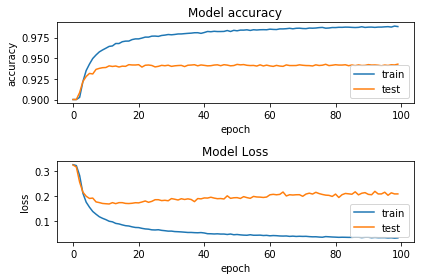

In [70]:
mp.figure()
# 绘制模型的准确率Accuracy曲线
mp.subplot(2,1,1)
mp.xlabel('epoch')
mp.ylabel('accuracy')
mp.title('Model accuracy')
mp.plot(history['acc'])
mp.plot(history['val_acc'])
mp.legend(['train','test'], loc='lower right')

# 绘制模型的损失值Loss曲线
mp.subplot(2,1,2)
mp.xlabel('epoch')
mp.ylabel('loss')
mp.title('Model Loss')
mp.plot(history['loss'])
mp.plot(history['val_loss'])
mp.legend(['train','test'], loc='lower right')
mp.tight_layout()

mp.show()

#### 小结
* 训练集的准确率accuracy和损失值loss表现都非常好；而测试集上的accuracy和loss表现非常糟糕，说明模型在10轮训练集后出现了过拟合现象。实际应用选择10轮训练的模型即可。